In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('../input/sign-language-mnist/sign_mnist_train.csv')

In [3]:
test_data = pd.read_csv('../input/sign-language-mnist/sign_mnist_test.csv')

In [4]:
train_data.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149


In [5]:
x = train_data.iloc[:,1:].values
print("Number of images: ", x.shape[0])

Number of images:  27455


In [6]:
labels = train_data['label']
train_data.drop('label', axis = 1, inplace = True)

In [7]:
unique_val = np.array(labels)
np.unique(unique_val)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [8]:
Training_image1 = train_data.values
Training_image1.shape

(27455, 784)

In [9]:
Training_images = train_data.values
Training_images = np.array([np.reshape(i, (28,28)) for i in Training_images])
images = np.array([i.flatten() for i in Training_images])
images = images/255
images.shape

(27455, 784)

In [10]:
from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(labels)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 101)

In [12]:
batch_size = 64
num_classes = 24
epochs = 50

In [13]:
#x_train = x_train / 255
#x_test = x_test / 255

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    rescale=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [16]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

In [17]:
x_train[0].shape

(28, 28, 1)

In [18]:
tt = datagen.flow(images[0].reshape(1,28,28,1))

In [19]:
imgs = [(next(tt)[0]) for _ in range(50)]

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [20]:
imgs[0].shape

(28, 28, 1)

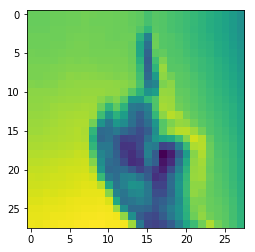

In [21]:
plt.imshow(imgs[0].reshape(28,28))

In [22]:
new_images=[]
new_labels=[]
for i in range(len(images)):
    tt= datagen.flow(images[i].reshape(1,28,28,1))
    labl = [labels[i] for _ in range(10)]
    imgs = [next(tt)[0] for _ in range(10)]
    new_images.append(imgs)
    new_labels.append(labl)

In [23]:
new_im = np.array(new_images)

In [24]:
im_pa = np.reshape(new_im,(27455*10,784))

In [25]:
lb_pa = np.reshape(new_labels,(27455*10,24))

(<matplotlib.image.AxesImage at 0x7fec32ca1518>,
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]))

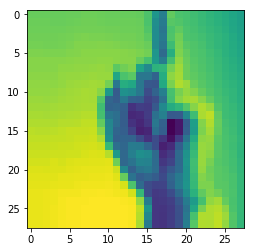

In [26]:
plt.imshow(im_pa[1].reshape(28,28)),lb_pa[1]

In [27]:
images.shape, im_pa.shape

((27455, 784), (274550, 784))

In [28]:
labels.shape,lb_pa.shape

((27455, 24), (274550, 24))

In [29]:
im_data = np.concatenate((images,im_pa))

In [30]:
label_data = np.concatenate((labels, lb_pa))

In [32]:
label_data.shape

(302005, 24)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(im_data, label_data, test_size = 0.2, random_state = 101)

In [34]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [35]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU

In [38]:
with tpu_strategy.scope():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1) ))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.20))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [39]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=epochs, batch_size=batch_size)

Train on 241604 samples, validate on 60401 samples
Epoch 1/50
241604/241604 [==============================] - 97s 402us/step - loss: 1.5922 - accuracy: 0.4808 - val_loss: 0.7907 - val_accuracy: 0.7301
Epoch 2/50
241604/241604 [==============================] - 97s 401us/step - loss: 0.6772 - accuracy: 0.7668 - val_loss: 0.6048 - val_accuracy: 0.7939
Epoch 3/50
241604/241604 [==============================] - 96s 399us/step - loss: 0.4521 - accuracy: 0.8436 - val_loss: 0.2778 - val_accuracy: 0.9056
Epoch 4/50
241604/241604 [==============================] - 96s 396us/step - loss: 0.3344 - accuracy: 0.8848 - val_loss: 0.2332 - val_accuracy: 0.9217
Epoch 5/50
241604/241604 [==============================] - 96s 396us/step - loss: 0.2703 - accuracy: 0.9085 - val_loss: 0.1597 - val_accuracy: 0.9478
Epoch 6/50
241604/241604 [==============================] - 96s 397us/step - loss: 0.2248 - accuracy: 0.9238 - val_loss: 0.1764 - val_accuracy: 0.9390
Epoch 7/50
241604/241604 [=================

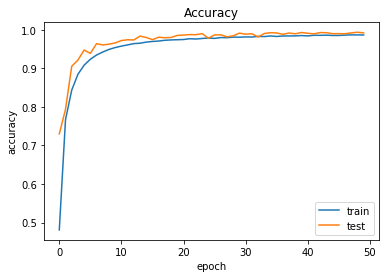

In [43]:

history.history.keys()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

In [ ]:
model.save('Aug_TPU_Sign.h5')